## Synthetic text creator for RAG system

In [94]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Import libraries**

In [95]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

**Reading data from Abastores**

In [96]:
df=pd.read_csv('data_abastores.csv')
df.head(5)

,Producto,Variedad,Familia,Fecha,Cantidad (t),Precio (€/t),Provincia,Comarca,id,data_source
0,Maíz,Nacional,Cereales,18-10-2022 00:00:00,0.0,350.75,León,Null,121003,31
1,Maíz,Nacional,Cereales,19-10-2022 00:00:00,NaN,348.75,León,NaN,139010,31
2,Maíz,Nacional,Cereales,20-10-2022 15:55:00,NaN,348.00,León,Castilla y León,163016,31
3,Maíz,Nacional,Cereales,20-10-2022 22:00:00,0.0,350.00,León,NaN,163856,31
4,Maíz,Nacional,Cereales,25-10-2022 14:19:00,NaN,353.00,León,Castilla y León,171047,31


**Data exploration**

In [97]:
# **Descripción:** Esta función crea un DataFrame que contiene los primeros 5 valores únicos de cada columna del DataFrame original.
examples_df = pd.DataFrame(columns=['Column_Name', 'Unique_Values'])

for column in df.columns:
    unique_values = df[column].unique()[:5]  # Take only the first 5 unique values
    d = {
        'Column_Name': [column],
        'Unique_Values': [unique_values]
    }
    examples_df = pd.concat([examples_df, pd.DataFrame(d)], ignore_index=True)
print(examples_df.shape)
examples_df.head(5)

(10, 2)


,Column_Name,Unique_Values
0,Producto,[Maíz]
1,Variedad,[Nacional]
2,Familia,[Cereales]
3,Fecha,"[18-10-2022 00:00:00, 19-10-2022 00:00:00, 20-..."
4,Cantidad (t),"[0.0, nan]"


In [98]:
print(df['Fecha'].min())
print(df['Fecha'].max())

01-02-2023 15:45:00
31-10-2023 17:40:00


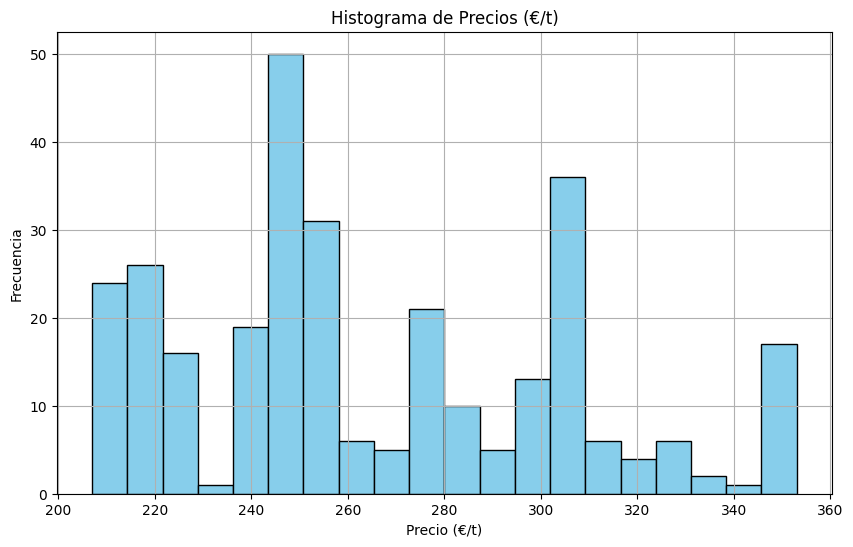

In [99]:
# Ahora, para plotear el histograma de la columna "Precio (€/t)"
plt.figure(figsize=(10, 6))  # Tamaño del gráfico opcional
plt.hist(df['Precio (€/t)'], bins=20, color='skyblue', edgecolor='black')  # Especifica el número de bins y los colores
plt.title('Histograma de Precios (€/t)')  # Título del gráfico
plt.xlabel('Precio (€/t)')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.grid(True)  # Agrega una cuadrícula al gráfico (opcional)
plt.show()

We are going to stay with the following columns: Producto, Fecha, Precio y Provincia

In [100]:
df_filt = df[['Producto','Fecha','Precio (€/t)','Provincia']]

In [101]:
df_filt=df_filt.copy()
df_filt.rename(columns={
            'Precio (€/t)':'precio',
            'Producto':'producto',
            'Fecha':'fecha',
            'Provincia':'provincia'
            },inplace=True)

In [102]:
df_filt['fecha']=pd.to_datetime(df_filt['fecha'],dayfirst=True)
df_filt['fecha']=df_filt['fecha'].dt.date

In [103]:
df_filt_1 = df_filt.copy()

df_filt_1.drop_duplicates(subset=['fecha'],inplace=True)

df_filt_1['fecha'] = pd.to_datetime(df_filt_1['fecha'])

# Set the 'fecha' column as the index
df_filt_1.set_index('fecha', inplace=True)

# Resample the DataFrame with a daily frequency and fill in missing values
df_daily = df_filt_1.resample('D').asfreq()

# Reset index to have 'fecha' as a column again
df_daily.reset_index(inplace=True)

# Forward fill missing values to fill gaps
df_daily = df_daily.ffill()

**Resampled data**

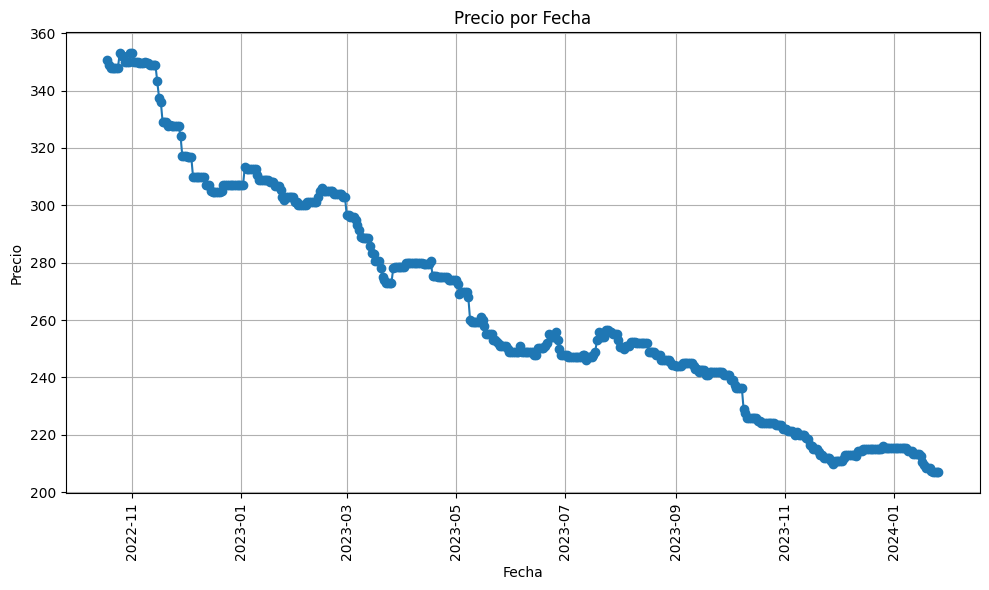

In [104]:
import matplotlib.pyplot as plt

# Graficar el precio por fecha
plt.figure(figsize=(10, 6))  # Tamaño del gráfico opcional
plt.plot(df_daily['fecha'], df_daily['precio'], marker='o', linestyle='-')  # Graficar el precio contra la fecha
plt.title('Precio por Fecha')  # Título del gráfico
plt.xlabel('Fecha')  # Etiqueta del eje x
plt.ylabel('Precio')  # Etiqueta del eje y
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mejor visualización
plt.grid(True)  # Agregar una cuadrícula al gráfico (opcional)
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


In [105]:
print(df_daily['fecha'].min())
print(df_daily['fecha'].max())

2022-10-18 00:00:00
2024-01-26 00:00:00


- So we have daily data from **18-10-2022** TO **26-01-2024**

In [106]:
# Creating a copy for the "maiz" product
df_daily_maiz=df_daily.copy()

In [107]:
# Creating new trigo information, same dates, different product.
df_daily_trigo=df_daily.copy()

In [108]:
df_daily_trigo['producto']='Trigo'
df_daily_trigo['provincia']='Barcelona'

We are going to add a variance to the price of the "trigo" to differentiate it from the "maiz" price

In [109]:
df_daily_trigo['precio']=df_daily_trigo['precio'] + 125.35

In [110]:
df_daily_trigo.head(5)

,fecha,producto,precio,provincia
0,2022-10-18,Trigo,476.10,Barcelona
1,2022-10-19,Trigo,474.10,Barcelona
2,2022-10-20,Trigo,473.35,Barcelona
3,2022-10-21,Trigo,473.35,Barcelona
4,2022-10-22,Trigo,473.35,Barcelona


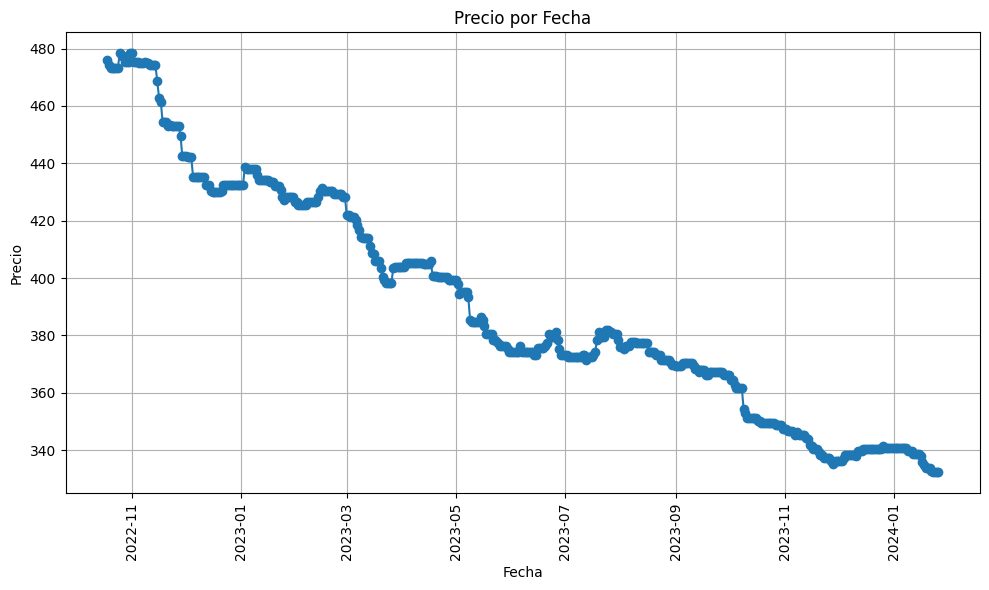

In [111]:
import matplotlib.pyplot as plt

# Graficar el precio por fecha
plt.figure(figsize=(10, 6))  # Tamaño del gráfico opcional
plt.plot(df_daily_trigo['fecha'], df_daily_trigo['precio'], marker='o', linestyle='-')  # Graficar el precio contra la fecha
plt.title('Precio por Fecha')  # Título del gráfico
plt.xlabel('Fecha')  # Etiqueta del eje x
plt.ylabel('Precio')  # Etiqueta del eje y
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mejor visualización
plt.grid(True)  # Agregar una cuadrícula al gráfico (opcional)
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


Now we are going to concatanete both of the dataframes to have a single dataframe with information of the two products (trigo and maiz)

In [112]:
df_concat = pd.concat([df_daily_trigo,df_daily_maiz])

In [113]:
df_concat

,fecha,producto,precio,provincia
0,2022-10-18,Trigo,476.10,Barcelona
1,2022-10-19,Trigo,474.10,Barcelona
2,2022-10-20,Trigo,473.35,Barcelona
3,2022-10-21,Trigo,473.35,Barcelona
4,2022-10-22,Trigo,473.35,Barcelona
...,...,...,...,...
461,2024-01-22,Maíz,207.50,León
462,2024-01-23,Maíz,207.00,León
463,2024-01-24,Maíz,207.00,León
464,2024-01-25,Maíz,207.00,León


In [115]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 932 entries, 0 to 465
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      932 non-null    datetime64[ns]
 1   producto   932 non-null    object        
 2   precio     932 non-null    float64       
 3   provincia  932 non-null    object        
 4   dia        932 non-null    int32         
 5   mes        932 non-null    int32         
 6   anio       932 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(2)
memory usage: 47.3+ KB


In [116]:
df_concat = df_concat.drop_duplicates(subset=['fecha', 'producto'])
df_concat

,fecha,producto,precio,provincia,dia,mes,anio
0,2022-10-18,Trigo,476.10,Barcelona,18,10,2022
1,2022-10-19,Trigo,474.10,Barcelona,19,10,2022
2,2022-10-20,Trigo,473.35,Barcelona,20,10,2022
3,2022-10-21,Trigo,473.35,Barcelona,21,10,2022
4,2022-10-22,Trigo,473.35,Barcelona,22,10,2022
...,...,...,...,...,...,...,...
461,2024-01-22,Maíz,207.50,León,22,1,2024
462,2024-01-23,Maíz,207.00,León,23,1,2024
463,2024-01-24,Maíz,207.00,León,24,1,2024
464,2024-01-25,Maíz,207.00,León,25,1,2024


In [117]:
# Define mappings
dia_mapping = {
    1: 'uno',
    2: 'dos',
    3: 'tres',
    4: 'cuatro',
    5: 'cinco',
    6: 'seis',
    7: 'siete',
    8: 'ocho',
    9: 'nueve',
    10: 'diez',
    11: 'once',
    12: 'doce',
    13: 'trece',
    14: 'catorce',
    15: 'quince',
    16: 'dieciséis',
    17: 'diecisiete',
    18: 'dieciocho',
    19: 'diecinueve',
    20: 'veinte',
    21: 'veintiuno',
    22: 'veintidós',
    23: 'veintitrés',
    24: 'veinticuatro',
    25: 'veinticinco',
    26: 'veintiséis',
    27: 'veintisiete',
    28: 'veintiocho',
    29: 'veintinueve',
    30: 'treinta',
    31: 'treinta y uno'
}

mes_mapping = {
    1: 'enero',
    2: 'febrero',
    3: 'marzo',
    4: 'abril',
    5: 'mayo',
    6: 'junio',
    7: 'julio',
    8: 'agosto',
    9: 'septiembre',
    10: 'octubre',
    11: 'noviembre',
    12: 'diciembre'
}

anio_mapping = {
    2022: 'dos mil veintidós',
    2023: 'dos mil veintitrés',
    2024: 'dos mil veinticuatro'
}

# Function to convert date components to strings
def convert_to_strings(row):
    dia_str = dia_mapping[row['dia']]
    mes_str = mes_mapping[row['mes']]
    anio_str = anio_mapping[row['anio']]
    return pd.Series([dia_str, mes_str, anio_str])

df_concat['dia_str']=''
df_concat['mes_str']=''
df_concat['anio_str']=''

# Apply the conversion function to each row
df_concat[['dia_str', 'mes_str', 'anio_str']] = df_concat[['dia', 'mes', 'anio']].apply(convert_to_strings, axis=1)

In [118]:
df_concat

,fecha,producto,precio,provincia,dia,mes,anio,dia_str,mes_str,anio_str
0,2022-10-18,Trigo,476.10,Barcelona,18,10,2022,dieciocho,octubre,dos mil veintidós
1,2022-10-19,Trigo,474.10,Barcelona,19,10,2022,diecinueve,octubre,dos mil veintidós
2,2022-10-20,Trigo,473.35,Barcelona,20,10,2022,veinte,octubre,dos mil veintidós
3,2022-10-21,Trigo,473.35,Barcelona,21,10,2022,veintiuno,octubre,dos mil veintidós
4,2022-10-22,Trigo,473.35,Barcelona,22,10,2022,veintidós,octubre,dos mil veintidós
...,...,...,...,...,...,...,...,...,...,...
461,2024-01-22,Maíz,207.50,León,22,1,2024,veintidós,enero,dos mil veinticuatro
462,2024-01-23,Maíz,207.00,León,23,1,2024,veintitrés,enero,dos mil veinticuatro
463,2024-01-24,Maíz,207.00,León,24,1,2024,veinticuatro,enero,dos mil veinticuatro
464,2024-01-25,Maíz,207.00,León,25,1,2024,veinticinco,enero,dos mil veinticuatro


In [119]:
df_concat['producto'].unique()

array(['Trigo', 'Maíz'], dtype=object)

In [120]:
df_concat = df_concat.sort_values(by='fecha')

# Inicializar la columna cambio_precio como cadena vacía
df_concat['cambio_precio'] = ''

# Iterar sobre los productos únicos
for producto in df_concat['producto'].unique():
    # Filtrar el DataFrame por producto
    df_producto = df_concat[df_concat['producto'] == producto]
    
    # Calcular la diferencia de precios entre días consecutivos
    df_producto['dif_precio'] = df_producto['precio'].diff()
    
    # Evaluar si el precio subió, bajó o se mantuvo igual en comparación con el día anterior
    df_producto.loc[df_producto['dif_precio'] > 0, 'cambio_precio'] = 'subió'
    df_producto.loc[df_producto['dif_precio'] < 0, 'cambio_precio'] = 'bajó'
    df_producto.loc[df_producto['dif_precio'] == 0, 'cambio_precio'] = 'se mantuvo igual'
    
    # Asignar los cambios de precio al DataFrame original
    df_concat.loc[df_concat['producto'] == producto, 'cambio_precio'] = df_producto['cambio_precio']

/var/folders/13/vtwv0p951k11cf7tvhd750jw0000gn/T/ipykernel_84465/3165770624.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_producto['dif_precio'] = df_producto['precio'].diff()
/var/folders/13/vtwv0p951k11cf7tvhd750jw0000gn/T/ipykernel_84465/3165770624.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_producto['dif_precio'] = df_producto['precio'].diff()


In [121]:
df_concat.loc[df_concat['cambio_precio']=='','cambio_precio']='se mantuvo igual'

In [122]:
df_concat['provincia'].value_counts()

provincia
Barcelona    466
León         466
Name: count, dtype: int64

In [123]:
noticias = [
    "Los precios del maíz alcanzan un nuevo máximo debido a la creciente demanda internacional.",
    "El trigo registra una subida del 10% en los últimos días debido a las preocupaciones sobre la oferta.",
    "La cosecha récord de arroz en Asia provoca una caída en los precios mundiales.",
    "Los precios del café experimentan una fuerte caída debido al exceso de oferta y la disminución de la demanda.",
    "Se pronostica una subida en los precios del cacao debido a las malas condiciones climáticas en las regiones productoras.",
    "La soja alcanza un precio récord en respuesta a la demanda china sin precedentes.",
    "Los precios del algodón se mantienen estables a pesar de las preocupaciones sobre la calidad del cultivo.",
    "El precio del petróleo crudo aumenta debido a las tensiones geopolíticas en Oriente Medio.",
    "Los precios del gas natural se desploman debido a la sobreoferta y la disminución de la demanda.",
    "Se espera que los precios del oro continúen su tendencia al alza como refugio seguro durante la incertidumbre económica.",
    "El cobre registra un aumento del 15% en las últimas semanas debido a la recuperación económica global.",
    "La caída en la producción de azúcar en Brasil impulsa los precios mundiales.",
    "Los precios del platino alcanzan su nivel más alto en años debido a la escasez de suministro.",
    "El zinc experimenta una fuerte caída debido a las preocupaciones sobre el exceso de oferta.",
    "Se espera una disminución en los precios del níquel debido a la desaceleración en la demanda de la industria automotriz.",
    "Los precios del mineral de hierro suben debido a la robusta demanda de China.",
    "La escasez de suministro de litio impulsa los precios a niveles récord.",
    "Los precios del aluminio se mantienen estables a pesar de las fluctuaciones en los mercados financieros.",
    "La demanda de harina de pescado impulsa los precios del pescado a niveles históricos.",
    "La carne de cerdo registra una caída del 20% debido a la sobreoferta y la disminución de la demanda en el mercado internacional.",
    "Se pronostica un aumento en los precios del ganado debido a las condiciones climáticas adversas que afectan la producción de forraje.",
    "La caída en la producción de aceite de palma en Indonesia y Malasia impulsa los precios mundiales."
]

In [124]:
df_concat['noticia'] = np.random.choice(noticias, size=len(df_concat))

In [125]:
df_concat.reset_index(inplace=True)
df_concat.drop(columns='index',inplace=True)

In [126]:
df_concat

,fecha,producto,precio,provincia,dia,mes,anio,dia_str,mes_str,anio_str,cambio_precio,noticia
0,2022-10-18,Trigo,476.10,Barcelona,18,10,2022,dieciocho,octubre,dos mil veintidós,se mantuvo igual,El cobre registra un aumento del 15% en las úl...
1,2022-10-18,Maíz,350.75,León,18,10,2022,dieciocho,octubre,dos mil veintidós,se mantuvo igual,Los precios del aluminio se mantienen estables...
2,2022-10-19,Trigo,474.10,Barcelona,19,10,2022,diecinueve,octubre,dos mil veintidós,bajó,La carne de cerdo registra una caída del 20% d...
3,2022-10-19,Maíz,348.75,León,19,10,2022,diecinueve,octubre,dos mil veintidós,bajó,La cosecha récord de arroz en Asia provoca una...
4,2022-10-20,Trigo,473.35,Barcelona,20,10,2022,veinte,octubre,dos mil veintidós,bajó,El trigo registra una subida del 10% en los úl...
...,...,...,...,...,...,...,...,...,...,...,...,...
927,2024-01-24,Trigo,332.35,Barcelona,24,1,2024,veinticuatro,enero,dos mil veinticuatro,se mantuvo igual,La caída en la producción de aceite de palma e...
928,2024-01-25,Maíz,207.00,León,25,1,2024,veinticinco,enero,dos mil veinticuatro,se mantuvo igual,La escasez de suministro de litio impulsa los ...
929,2024-01-25,Trigo,332.35,Barcelona,25,1,2024,veinticinco,enero,dos mil veinticuatro,se mantuvo igual,El zinc experimenta una fuerte caída debido a ...
930,2024-01-26,Trigo,332.35,Barcelona,26,1,2024,veintiséis,enero,dos mil veinticuatro,se mantuvo igual,El zinc experimenta una fuerte caída debido a ...


In [127]:
print(f'En la provincia {df_concat["provincia"][0]}' + f' el precio del {df_concat["producto"][0]}'\
     + f' para el dia {df_concat["dia"][0]} ({df_concat["dia_str"][0]}) del mes {df_concat["mes"][0]} ({df_concat["mes_str"][0]}) del año {df_concat["anio"][0]} ({df_concat["anio_str"][0]})'\
     + f' fue de {df_concat["precio"][0]} euros por tonelada.' + f'El precio {df_concat["cambio_precio"][0]}'\
     + f' debido a la siguiente noticia {df_concat["noticia"][0]}')


En la provincia Barcelona el precio del Trigo para el dia 18 (dieciocho) del mes 10 (octubre) del año 2022 (dos mil veintidós) fue de 476.1 euros por tonelada.El precio se mantuvo igual debido a la siguiente noticia El cobre registra un aumento del 15% en las últimas semanas debido a la recuperación económica global.


In [128]:
test_text = f'En la provincia {df_concat["provincia"][0]}' + f' el precio del {df_concat["producto"][0]}'\
     + f' para el dia {df_concat["dia"][0]} del mes {df_concat["mes"][0]} del año {df_concat["anio"][0]}'\
     + f' fue de {df_concat["precio"][0]} euros por tonelada.' + f'El precio {df_concat["cambio_precio"][0]}'\
     + f' debido a la siguiente noticia {df_concat["noticia"][0]}'

In [129]:
print('Number of tokens: ' + f'{round(len(test_text)/4,0)}')

Number of tokens: 69.0


In [130]:
str(df_concat['provincia'][0])

'Barcelona'

In [131]:
df_concat

,fecha,producto,precio,provincia,dia,mes,anio,dia_str,mes_str,anio_str,cambio_precio,noticia
0,2022-10-18,Trigo,476.10,Barcelona,18,10,2022,dieciocho,octubre,dos mil veintidós,se mantuvo igual,El cobre registra un aumento del 15% en las úl...
1,2022-10-18,Maíz,350.75,León,18,10,2022,dieciocho,octubre,dos mil veintidós,se mantuvo igual,Los precios del aluminio se mantienen estables...
2,2022-10-19,Trigo,474.10,Barcelona,19,10,2022,diecinueve,octubre,dos mil veintidós,bajó,La carne de cerdo registra una caída del 20% d...
3,2022-10-19,Maíz,348.75,León,19,10,2022,diecinueve,octubre,dos mil veintidós,bajó,La cosecha récord de arroz en Asia provoca una...
4,2022-10-20,Trigo,473.35,Barcelona,20,10,2022,veinte,octubre,dos mil veintidós,bajó,El trigo registra una subida del 10% en los úl...
...,...,...,...,...,...,...,...,...,...,...,...,...
927,2024-01-24,Trigo,332.35,Barcelona,24,1,2024,veinticuatro,enero,dos mil veinticuatro,se mantuvo igual,La caída en la producción de aceite de palma e...
928,2024-01-25,Maíz,207.00,León,25,1,2024,veinticinco,enero,dos mil veinticuatro,se mantuvo igual,La escasez de suministro de litio impulsa los ...
929,2024-01-25,Trigo,332.35,Barcelona,25,1,2024,veinticinco,enero,dos mil veinticuatro,se mantuvo igual,El zinc experimenta una fuerte caída debido a ...
930,2024-01-26,Trigo,332.35,Barcelona,26,1,2024,veintiséis,enero,dos mil veinticuatro,se mantuvo igual,El zinc experimenta una fuerte caída debido a ...


**Exporting the raw data that will be used to create sentences**

In [132]:
df_concat.to_csv('raw_data.csv',index=False)

**Creating new dataframe with sentences we are going to use for the RAG system**

In [538]:
df_concat['text']=''
# Crear la columna deseada con la estructura especificada
df_concat['text'] = df_concat.apply(lambda row: 
    f'En la provincia {row["provincia"]} el precio del {row["producto"]} para el día {row["dia"]} ({row["dia_str"]}) del mes {row["mes"]} ({row["mes_str"]}) del año {row["anio"]} ({row["anio_str"]}) fue de {row["precio"]} euros por tonelada. El precio {row["cambio_precio"]} debido a la siguiente noticia: {row["noticia"]}', 
    axis=1)

In [539]:
df_concat['provincia'].value_counts()

provincia
Barcelona    466
León         466
Name: count, dtype: int64

In [540]:
df_chunk=df_concat[['text','mes','anio','producto']]

In [399]:
pages_and_chunks=[]
for item in tqdm(df_chunk):
    for sentence_chunk in df_chunk['text']:
        chunk_dict={}
        joined_sentence_chunk="".join(sentence_chunk).replace(" "," ").strip()
        joined_sentence_chunk=re.sub(r'\.([A-Z])',r'. \1',joined_sentence_chunk)
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4 # 1 token =~ 4 chars

        chunk_dict["mes"] = row["mes"]
        chunk_dict["anio"] = row["anio"]
        pages_and_chunks.append(chunk_dict)

  0%|          | 3/932 [00:00<00:06, 144.74it/s]


In [541]:
pages_and_chunks = []

for index, row in tqdm(df_chunk.iterrows(), total=len(df_chunk)):
    chunk_dict = {}
    joined_sentence_chunk = row['text'].replace(" ", " ").strip()
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)

    chunk_dict["sentence_chunk"] = joined_sentence_chunk
    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len(joined_sentence_chunk.split(" "))
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4  # 1 token =~ 4 chars

    # Add 'mes' and 'anio' columns from df_chunk to chunk_dict
    chunk_dict["mes"] = row["mes"]
    chunk_dict["anio"] = row["anio"]
    chunk_dict["producto"] = row["producto"]

    pages_and_chunks.append(chunk_dict)


100%|██████████| 932/932 [00:00<00:00, 42858.61it/s]


In [542]:
df = pd.DataFrame(pages_and_chunks)
df

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,mes,anio,producto
0,En la provincia Barcelona el precio del Trigo ...,316,56,79.00,10,2022,Trigo
1,En la provincia León el precio del Maíz para e...,304,54,76.00,10,2022,Maíz
2,En la provincia Barcelona el precio del Trigo ...,278,49,69.50,10,2022,Trigo
3,En la provincia León el precio del Maíz para e...,322,56,80.50,10,2022,Maíz
4,En la provincia Barcelona el precio del Trigo ...,295,52,73.75,10,2022,Trigo
...,...,...,...,...,...,...,...
927,En la provincia Barcelona el precio del Trigo ...,324,56,81.00,1,2024,Trigo
928,En la provincia León el precio del Maíz para e...,299,53,74.75,1,2024,Maíz
929,En la provincia Barcelona el precio del Trigo ...,325,55,81.25,1,2024,Trigo
930,En la provincia Barcelona el precio del Trigo ...,297,53,74.25,1,2024,Trigo


In [543]:
# Agrupar por mes y año y concatenar los textos de sentence_chunk
grouped_chunks = df.groupby(['mes', 'anio','producto']).agg({
    'sentence_chunk': ' '.join,
    'chunk_char_count': 'sum',
    'chunk_word_count': 'sum',
    'chunk_token_count': 'sum'
}).reset_index()

# Verificar el resultado
print(grouped_chunks)


    mes  anio producto                                     sentence_chunk  \
0     1  2023     Maíz  En la provincia León el precio del Maíz para e...   
1     1  2023    Trigo  En la provincia Barcelona el precio del Trigo ...   
2     1  2024     Maíz  En la provincia León el precio del Maíz para e...   
3     1  2024    Trigo  En la provincia Barcelona el precio del Trigo ...   
4     2  2023     Maíz  En la provincia León el precio del Maíz para e...   
5     2  2023    Trigo  En la provincia Barcelona el precio del Trigo ...   
6     3  2023     Maíz  En la provincia León el precio del Maíz para e...   
7     3  2023    Trigo  En la provincia Barcelona el precio del Trigo ...   
8     4  2023     Maíz  En la provincia León el precio del Maíz para e...   
9     4  2023    Trigo  En la provincia Barcelona el precio del Trigo ...   
10    5  2023     Maíz  En la provincia León el precio del Maíz para e...   
11    5  2023    Trigo  En la provincia Barcelona el precio del Trigo ...   

In [544]:
pages_and_chunks

[{'sentence_chunk': 'En la provincia Barcelona el precio del Trigo para el día 18 (dieciocho) del mes 10 (octubre) del año 2022 (dos mil veintidós) fue de 476.1 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: La caída en la producción de aceite de palma en Indonesia y Malasia impulsa los precios mundiales.',
  'chunk_char_count': 316,
  'chunk_word_count': 56,
  'chunk_token_count': 79.0,
  'mes': 10,
  'anio': 2022,
  'producto': 'Trigo'},
 {'sentence_chunk': 'En la provincia León el precio del Maíz para el día 18 (dieciocho) del mes 10 (octubre) del año 2022 (dos mil veintidós) fue de 350.75 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: El zinc experimenta una fuerte caída debido a las preocupaciones sobre el exceso de oferta.',
  'chunk_char_count': 304,
  'chunk_word_count': 54,
  'chunk_token_count': 76.0,
  'mes': 10,
  'anio': 2022,
  'producto': 'Maíz'},
 {'sentence_chunk': 'En la provincia Barcelona el precio del Tr

In [545]:
# Convert the DataFrame to dictionary
grouped_chunks_dict = grouped_chunks.to_dict(orient='records')

# Verify the result
print(grouped_chunks_dict)

[{'mes': 1, 'anio': 2023, 'producto': 'Maíz', 'sentence_chunk': 'En la provincia León el precio del Maíz para el día 1 (uno) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 307.25 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Los precios del algodón se mantienen estables a pesar de las preocupaciones sobre la calidad del cultivo. En la provincia León el precio del Maíz para el día 2 (dos) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 307.25 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Se pronostica una subida en los precios del cacao debido a las malas condiciones climáticas en las regiones productoras. En la provincia León el precio del Maíz para el día 3 (tres) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 313.5 euros por tonelada. El precio subió debido a la siguiente noticia: Los precios del café experimentan una fuerte caída debido al exceso de oferta y la disminución de la demand

In [546]:
pages_and_chunks=grouped_chunks_dict.copy()

In [547]:
pages_and_chunks

[{'mes': 1,
  'anio': 2023,
  'producto': 'Maíz',
  'sentence_chunk': 'En la provincia León el precio del Maíz para el día 1 (uno) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 307.25 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Los precios del algodón se mantienen estables a pesar de las preocupaciones sobre la calidad del cultivo. En la provincia León el precio del Maíz para el día 2 (dos) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 307.25 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Se pronostica una subida en los precios del cacao debido a las malas condiciones climáticas en las regiones productoras. En la provincia León el precio del Maíz para el día 3 (tres) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 313.5 euros por tonelada. El precio subió debido a la siguiente noticia: Los precios del café experimentan una fuerte caída debido al exceso de oferta y la disminución de la 

**Embedding our text chunks**

In [548]:
!pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [549]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

In [550]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]
text_chunks[0]

'En la provincia León el precio del Maíz para el día 1 (uno) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 307.25 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Los precios del algodón se mantienen estables a pesar de las preocupaciones sobre la calidad del cultivo. En la provincia León el precio del Maíz para el día 2 (dos) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 307.25 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Se pronostica una subida en los precios del cacao debido a las malas condiciones climáticas en las regiones productoras. En la provincia León el precio del Maíz para el día 3 (tres) del mes 1 (enero) del año 2023 (dos mil veintitrés) fue de 313.5 euros por tonelada. El precio subió debido a la siguiente noticia: Los precios del café experimentan una fuerte caída debido al exceso de oferta y la disminución de la demanda. En la provincia León el precio del Maíz para el día 4 (cuatro

In [551]:
len(text_chunks)

32

**Embedding texts**

In [566]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=30,#You can experiment to find which batch size leads to best results
                                               convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 25.2 s, sys: 11.2 s, total: 36.4 s
Wall time: 5.41 s


tensor([[-0.0032,  0.0321, -0.0094,  ...,  0.0142, -0.0693,  0.0095],
        [-0.0114, -0.0204, -0.0051,  ...,  0.0062, -0.0620,  0.0099],
        [-0.0288,  0.0443, -0.0029,  ..., -0.0033, -0.0751,  0.0090],
        ...,
        [-0.0092, -0.0034, -0.0041,  ..., -0.0102, -0.0950,  0.0052],
        [-0.0147,  0.0096, -0.0120,  ..., -0.0053, -0.0756,  0.0273],
        [-0.0264, -0.0095, -0.0006,  ..., -0.0094, -0.0974,  0.0058]])

In [568]:
for item in tqdm(pages_and_chunks):
    item['embedding'] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


In [569]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path,index=False)

In [570]:
# Import saved file and view
text_chunks_and_embedding_df_load=pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,mes,anio,producto,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,2023,Maíz,En la provincia León el precio del Maíz para e...,9383,1712,2345.75,[-3.21558351e-03 3.21119837e-02 -9.43434797e-...
1,1,2023,Trigo,En la provincia Barcelona el precio del Trigo ...,9574,1706,2393.50,[-1.13802124e-02 -2.03716531e-02 -5.13769547e-...
2,1,2024,Maíz,En la provincia León el precio del Maíz para e...,7757,1407,1939.25,[-2.88416483e-02 4.42610011e-02 -2.88942503e-...
3,1,2024,Trigo,En la provincia Barcelona el precio del Trigo ...,7979,1408,1994.75,[-9.09643155e-03 -1.24795279e-02 -6.02733856e-...
4,2,2023,Maíz,En la provincia León el precio del Maíz para e...,8428,1527,2107.00,[ 7.69581005e-04 1.28346682e-02 -5.02413977e-...


In [572]:
import random

import torch
import numpy as np
import pandas as pd

device = "cpu"

# Import text and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"),sep=" "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(),axis=0),dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

#text_chunks_and_embedding_df

In [573]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

In [595]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "maiz"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cpu")

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=10)
top_results_dot_product

print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score,idx in zip(top_results_dot_product[0],top_results_dot_product[1]):
  print(f"Score: {score:.4f}")
  print("Text:")
  print(pages_and_chunks[idx]["sentence_chunk"])
  print("\n")

Query: maiz
[INFO] Time take to get scores on 32 embeddings: 0.00013 seconds.
Results:
Score: 0.1405
Text:
En la provincia León el precio del Maíz para el día 1 (uno) del mes 1 (enero) del año 2024 (dos mil veinticuatro) fue de 215.5 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Los precios del algodón se mantienen estables a pesar de las preocupaciones sobre la calidad del cultivo. En la provincia León el precio del Maíz para el día 2 (dos) del mes 1 (enero) del año 2024 (dos mil veinticuatro) fue de 215.5 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Los precios del algodón se mantienen estables a pesar de las preocupaciones sobre la calidad del cultivo. En la provincia León el precio del Maíz para el día 3 (tres) del mes 1 (enero) del año 2024 (dos mil veinticuatro) fue de 215.5 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: La cosecha récord de arroz en Asia provoca una caída en los preci

In [590]:
# Import cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity scores
start_time = timer()
cosine_scores = cosine_similarity(query_embedding.reshape(1, -1), embeddings)
end_time = timer()

print(f"[INFO] Time taken to compute cosine similarity scores: {end_time - start_time:.5f} seconds.")

# Convert cosine similarity scores to torch tensor for torch.topk
cosine_scores_tensor = torch.tensor(cosine_scores[0])

# Get the top-k results
top_results_cosine_similarity = torch.topk(cosine_scores_tensor, k=10)

print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_cosine_similarity[0], top_results_cosine_similarity[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print("\n")


[INFO] Time taken to compute cosine similarity scores: 0.01773 seconds.
Results:
Score: 0.6437
Text:
En la provincia Barcelona el precio del Trigo para el día 1 (uno) del mes 1 (enero) del año 2024 (dos mil veinticuatro) fue de 340.85 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Se espera una disminución en los precios del níquel debido a la desaceleración en la demanda de la industria automotriz. En la provincia Barcelona el precio del Trigo para el día 2 (dos) del mes 1 (enero) del año 2024 (dos mil veinticuatro) fue de 340.85 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Los precios del maíz alcanzan un nuevo máximo debido a la creciente demanda internacional. En la provincia Barcelona el precio del Trigo para el día 3 (tres) del mes 1 (enero) del año 2024 (dos mil veinticuatro) fue de 340.85 euros por tonelada. El precio se mantuvo igual debido a la siguiente noticia: Se espera que los precios del oro continúen su ten

In [608]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "precio del maíz para febrero 2023"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cpu")


# Convert text chunks to list of strings
text_chunk_strings = [item["sentence_chunk"] for item in pages_and_chunks]

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform text chunks to create BoW representation
text_chunk_bow = vectorizer.fit_transform(text_chunk_strings)

# Transform query to BoW representation
query_bow = vectorizer.transform([query])

# Compute cosine similarity between query BoW and text chunks BoW
bow_scores = cosine_similarity(query_bow, text_chunk_bow)[0]

# Weighting factors
dot_weight = 0.7  # Weight for dot product similarity scores
bow_weight = 0.3  # Weight for BoW similarity scores
print('dot_scores:',dot_scores)
print('bow_scores:',bow_scores)

# Combine dot product scores and BoW scores
final_scores = dot_weight * dot_scores + bow_weight * bow_scores

# Get top-k results
top_results_final = torch.topk(final_scores, k=10)

print("Results with combined scores:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_final[0], top_results_final[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print("\n")

Query: precio del maíz para febrero 2023
dot_scores: tensor([0.1100, 0.0723, 0.1405, 0.1259, 0.0740, 0.0698, 0.1393, 0.0588, 0.0918,
        0.0902, 0.1044, 0.0696, 0.1145, 0.0828, 0.1069, 0.0642, 0.1130, 0.0863,
        0.0986, 0.0997, 0.0690, 0.0615, 0.1139, 0.0802, 0.1177, 0.0433, 0.0958,
        0.0846, 0.1059, 0.0688, 0.1076, 0.0727])
bow_scores: [0.4242592  0.37309102 0.37189198 0.33856261 0.46549792 0.43197731
 0.43406476 0.38218125 0.41402813 0.37278665 0.42318735 0.37032235
 0.43743299 0.38244221 0.42552022 0.3738215  0.42654272 0.37049082
 0.4218973  0.38465338 0.37651628 0.32223164 0.41730684 0.37497874
 0.38043253 0.33649767 0.42539683 0.36783993 0.38085688 0.32172797
 0.42504921 0.36573366]
Results with combined scores:
Score: 0.2277
Text:
En la provincia León el precio del Maíz para el día 1 (uno) del mes 3 (marzo) del año 2023 (dos mil veintitrés) fue de 296.5 euros por tonelada. El precio bajó debido a la siguiente noticia: El trigo registra una subida del 10% en los úl

In [604]:
embeddings.shape

torch.Size([32, 768])

In [450]:
import textwrap

def print_wrapped(text,wrap_length=80):
  wrapped_text = textwrap.fill(text,wrap_length)
  print(wrapped_text)